In [1]:
import cpuinfo
if "Intel" in cpuinfo.get_cpu_info()['brand_raw']:
    from sklearnex import patch_sklearn
    patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
os.chdir("..")

In [3]:
import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
SAMPLE_SIZE = 300
root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/train"
mel_imgs = np.random.choice(list((chall1/'mel').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)
bcc_imgs = np.random.choice(list((chall1/'bcc').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)
scc_imgs = np.random.choice(list((chall1/'scc').glob("*inpaint_0_5.png")), SAMPLE_SIZE, replace=False)

test_imgs = np.concatenate([mel_imgs, bcc_imgs, scc_imgs])

brisk = cv2.BRISK_create(thresh=30, octaves=0)


color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV,   'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius


dense_brisk_color = ColorDescriptor(brisk, color_spaces,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25)

dense_brisk = DenseDescriptor(descriptor=brisk, min_keypoints=100, max_keypoints=500, kp_size=10)


In [9]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls)


descriptors_color = []
img_classes_color = []
with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)

  0%|          | 0/900 [00:00<?, ?it/s]/home/vzalevskyi/anaconda3/envs/cad/lib/python3.10/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:83: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(pixels),
/home/vzalevskyi/uni/MAIA_Semester_3/cad/skin-lesion-cad/skin_lesion_cad/features/colour.py:84: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(pixels),
100%|██████████| 900/900 [24:20<00:00,  1.62s/it]  


In [ ]:
def _load_and_extract_des(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, mask)
    return (des, img_cls)

descriptors = []
img_classes = []

with Pool(8) as pool:
    for (des, img_cls) in tqdm(pool.imap(_load_and_extract_des,
                                       zip(test_imgs,
                                           [dense_brisk]*len(test_imgs))), total=len(test_imgs)):
        descriptors.append(des)
        img_classes.append(img_cls)

In [9]:
# # BRISK doesnt output a stable number of keypoints after .compute()
# _load_and_extract_des((test_imgs[10], dense_brisk))[0].shape

In [10]:
pd.to_pickle((descriptors_color, img_classes_color), 'descriptors_color_3cls.pkl')
pd.to_pickle((descriptors, img_classes), 'descriptors_brisk_3cls.pkl')
# descriptors, img_classes = pd.read_pickle('descriptors.pkl')

1500 500 64


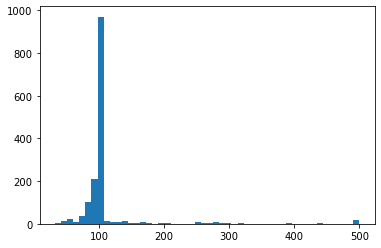

In [11]:
print(len(descriptors), len(descriptors_color[0]), len(descriptors[0][0]))
plt.hist([len(d) for d in descriptors], bins=50)
plt.show()

1500 500 96


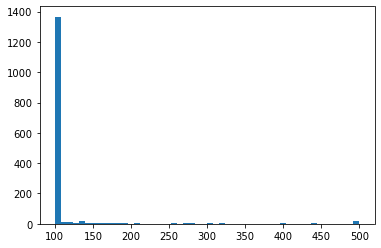

In [12]:
print(len(descriptors_color), len(descriptors_color[0]), len(descriptors_color[0][0]))
plt.hist([len(d) for d in descriptors_color], bins=50)
plt.show()

Brisk Dense

In [9]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, img_classes, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000, class_weight='balanced', random_state=42)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred, average="macro")}')

              precision    recall  f1-score   support

           0       0.55      0.24      0.33       117
           1       0.51      0.57      0.54        94
           2       0.40      0.65      0.49        86

    accuracy                           0.46       297
   macro avg       0.49      0.49      0.46       297
weighted avg       0.49      0.46      0.45       297

Accuracy: 0.46464646464646464

Confusion Matrix: 
[[28 33 56]
 [11 54 29]
 [12 18 56]]
f1_score: 0.4564796572190369


Color descriptors

In [10]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_color, img_classes_color, test_size=0.33, random_state=42)

bovw = BagofWords(n_words=100, n_jobs=-1, random_state=None)
classifier = SVC(max_iter=10000, class_weight='balanced', random_state=42)

X_train_preprocessed = bovw.fit_transform(X_train,y_train) 
X_test_preprocessed = bovw.transform(X_test)

classifier.fit(X_train_preprocessed,y_train)
y_pred = classifier.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.48      0.40      0.44       117
           1       0.65      0.59      0.62        94
           2       0.36      0.49      0.42        86

    accuracy                           0.48       297
   macro avg       0.50      0.49      0.49       297
weighted avg       0.50      0.48      0.49       297

Accuracy: 0.48484848484848486

Confusion Matrix: 
[[47 16 54]
 [19 55 20]
 [31 13 42]]


Pure color features

In [11]:
proc_data = Path().resolve() / 'data/processed'
chl = 'chall2'
mode = 'train'
feat_type = 'raw'


test_path = proc_data / f'{chl}/{mode}'
print('\nAnalyzing features for', feat_type)

bcc_data = pd.read_feather(test_path / f'bcc_color_features_{feat_type}_full_image.feather').set_index('name')
bcc_data['class'] = 0

mel_data = pd.read_feather(test_path/ f'mel_color_features_{feat_type}_full_image.feather').set_index('name')
mel_data['class'] = 1

scc_data = pd.read_feather(test_path/ f'scc_color_features_{feat_type}_full_image.feather').set_index('name')
scc_data['class'] = 2

data = pd.concat([scc_data, bcc_data, mel_data])

current_test_data = data.loc[[str(x.name).split('_')[0] for x in test_imgs]]
current_test_data


Analyzing features for raw


,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,class
name,,,,,,,,,,,,,,,,,,,,,
mel00955,46.258518,72.506821,1.362645,0.623051,255.0,0.0,11.337113,256,36.752369,62.359688,...,15763,5.865253,11.048288,2.137819,4.300450,65.085899,-28.226221,-inf,15214,1
mel00188,184.005615,14.344368,-1.241415,2.699086,212.0,94.0,11.116725,115,143.829498,23.828716,...,3739,18.203936,7.861330,1.288837,0.735568,48.821266,6.440615,11.036789,3663,1
mel02037,165.395096,55.755661,-1.608248,1.322682,214.0,0.0,12.397109,215,151.621063,56.151627,...,5383,10.091539,6.097158,0.796383,1.346088,32.748959,-11.367688,-inf,5381,1
mel01558,90.218353,36.986023,0.921862,0.551126,228.0,11.0,12.396964,217,72.719543,26.739733,...,4800,10.218871,9.169182,0.469676,-0.580637,34.916409,-13.035437,-inf,4800,1
mel01829,158.611954,24.197397,-2.350578,6.008992,191.0,22.0,11.106165,169,133.755432,32.663395,...,4576,10.030925,6.062141,0.830149,0.651457,38.284050,-6.245440,-inf,4569,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00293,105.319183,80.629684,-0.286361,-1.764383,204.0,0.0,12.080642,205,94.125237,73.601257,...,4521,6.247361,7.373171,1.450512,1.131275,35.323055,-3.341404,-inf,4521,2
scc00095,102.385529,79.525604,-0.331207,-1.779462,188.0,0.0,12.051423,189,89.158295,69.358521,...,5666,5.109551,5.917442,1.525853,3.154506,46.616589,-11.055236,-inf,5665,2
scc00236,68.935890,96.711136,0.797532,-1.297982,233.0,0.0,11.446862,234,54.724030,77.062538,...,5488,6.146390,8.699011,1.219141,0.221055,53.418995,-1.885718,-inf,5488,2


In [12]:

all_X = current_test_data.drop(columns=['class']).values
all_y = current_test_data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.61      0.49      0.54       111
           1       0.69      0.63      0.66        83
           2       0.40      0.55      0.46        76

    accuracy                           0.55       270
   macro avg       0.57      0.56      0.55       270
weighted avg       0.57      0.55      0.55       270

Accuracy: 0.5481481481481482

Confusion Matrix: 
[[54 12 45]
 [12 52 19]
 [23 11 42]]
